# Assembling

This notebook is used to assemble a processable h5ad object for subsequent notebooks.

## Fill in input data, output and settings

In [ ]:
####################### TEST NAME ###################################
test = 'sample1'
################### DEFINING STRATEGY ###############################
from_h5ad = True #option 1
assembling_10_velocity = False #option 2
assembling_10_public = False #option 3
convert_seurat = False #option 4

###################### INPUT DATA ###################################

# For option 1: The path to an existing .h5ad file
h5ad_files = ['/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Glaser_11_22/preprocessing_output/data/sample1/sample1_annotated_peaks.h5ad']
from_snapatac = False # This is True when the sample is preprocessed using SnapATAC
# Manually set existing QC Columns
n_features_by_counts = None
log1p_n_features_by_counts = None
total_counts = None
log1p_total_counts = None
mean_insertsize = None
insertsize_count = None
n_total_fragments = None
n_fragments_in_promoters = None
pct_fragments_in_promoters = None
blacklist_overlaps = None
# total_number_of_fragments
TN = None # 'TN'
# uniquely_mapped_fragments
UM = None # 'UM'
# properly_paired_fragments
PP = None # 'PP'
# uniq_fragments
UQ = None # 'UQ'
# chrM_fragments
CM = None # 'CM'

#################### Calc QC Columns ###############################
# set available number of threads
n_threads = 8

# if the mean_insertsize should be calculated specify either a BAM file or a fragments file:
use_bam = True # False if fragments should be used
barcode_tag = 'SB'
bam_file = '/mnt/workspace/jdetlef/ext_ana/ext442/sample1.filter.bam'
fragments_file = None 

# specify promotors_gtf if another promoter than the fixed ones should be used
# if promotors is None please specify species
# promoters_gtf =  '/mnt/flatfiles/organisms/new_organism/homo_sapiens/104/homo_sapiens.104.promoters2000.gtf'
promoters_gtf = '/mnt/workspace/jdetlef/ext_ana/mus_musculus.104.promoters2000.gtf'
species = None

##################### OUTPUT DATA ###################################
output_dir = '/mnt/workspace/jdetlef/ext_ana/processed'

## Import modules

In [ ]:
# sctoolbox modules 
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.fragment_length as fragments
import sctoolbox.atac as atac
import sctoolbox.calc_overlap_pct as overlap
import sctoolbox.analyser 
from sctoolbox.qc_filter import *
from sctoolbox.atac_utils import *
# import episcanpy
import episcanpy as epi

## Setup path handling object 

In [ ]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

## Read in data

### Option 1: Read from .h5ad

In [4]:
qc_columns = {}
qc_columns["n_features_by_counts"] = n_features_by_counts
qc_columns["log1p_n_features_by_counts"] = log1p_n_features_by_counts
qc_columns["total_counts"] = total_counts
qc_columns["log1p_total_counts"] = log1p_total_counts
qc_columns["mean_insertsize"] = mean_insertsize
qc_columns['n_total_fragments'] = n_total_fragments
qc_columns['n_fragments_in_promoters'] = n_fragments_in_promoters
qc_columns['pct_fragments_in_promoters'] = pct_fragments_in_promoters
qc_columns["blacklist_overlaps"] = blacklist_overlaps
qc_columns["TN"] = TN
qc_columns["UM"] = UM
qc_columns["PP"] = PP
qc_columns["UQ"] = UQ
qc_columns["CM"] = CM

In [5]:
if from_h5ad:
    
    adata = assemble_from_h5ad(h5ad_files=h5ad_files, from_snapatac=from_snapatac, qc_columns=qc_columns)

peak_columns is not set. Please set peak_columns to rename adata.var columns to peak_chr, peak_start, peak_end
add existing adata.obs columns to infoprocess:

setting adata.obs.index.name = barcode


## Inspect adata

In [6]:
display(adata)

AnnData object with n_obs × n_vars = 8371 × 148517
    obs: 'chr1_reads', 'chr10_reads', 'chr11_reads', 'chr12_reads', 'chr13_reads', 'chr14_reads', 'chr15_reads', 'chr16_reads', 'chr17_reads', 'chr18_reads', 'chr19_reads', 'chr2_reads', 'chr3_reads', 'chr4_reads', 'chr5_reads', 'chr6_reads', 'chr7_reads', 'chr8_reads', 'chr9_reads', 'chrM_reads', 'chrX_reads', 'chrY_reads', 'total_genome_reads', 'insertsize_mean', 'Sample', 'id', 'condition', 'date', 'file', 'sample'
    var: 'peak_chr', 'peak_start', 'peak_end', 'peak_id', 'peak_score', 'peak_strand', 'feature', 'gene_start', 'gene_end', 'gene_strand', 'gene_anchor', 'distance_to_gene', 'relative_location_to_gene', 'gene_ovl_peak', 'peak_ovl_gene', 'gene_biotype', 'gene_id', 'gene_name', 'annotation_query', 'region_length'
    uns: 'insertsize_table', 'scATACseq.preprocessing', 'infoprocess', 'color_set'
    layers: 'binarized'

In [7]:
adata.var

,peak_chr,peak_start,peak_end,peak_id,peak_score,peak_strand,feature,gene_start,gene_end,gene_strand,gene_anchor,distance_to_gene,relative_location_to_gene,gene_ovl_peak,peak_ovl_gene,gene_biotype,gene_id,gene_name,annotation_query,region_length
annotated_peaks_0_chr1:3050427-3050801,chr1,3050427,3050801,peak_1,.,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,374
annotated_peaks_100000_chr4:129518038-129518515,chr4,129518038,129518515,peak_100001,.,.,gene,129513066.0,129517740.0,-,start,536.0,Upstream,0.0,0.0,protein_coding,ENSMUSG00000028795,Ccdc28b,protein_coding_promoter,477
annotated_peaks_100001_chr4:129518849-129519134,chr4,129518849,129519134,peak_100002,.,.,gene,129513066.0,129517740.0,-,start,1251.0,Upstream,0.0,0.0,protein_coding,ENSMUSG00000028795,Ccdc28b,protein_coding_promoter,285
annotated_peaks_100002_chr4:129527627-129527883,chr4,129527627,129527883,peak_100003,.,.,gene,129519870.0,129534858.0,-,center,391.0,PeakInsideFeature,1.0,0.017,protein_coding,ENSMUSG00000053841,Txlna,protein_coding_internal,256
annotated_peaks_100003_chr4:129533947-129534180,chr4,129533947,129534180,peak_100004,.,.,gene,129519870.0,129534858.0,-,start,795.0,PeakInsideFeature,1.0,0.016,protein_coding,ENSMUSG00000053841,Txlna,protein_coding_promoter,233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
annotated_peaks_99999_chr4:129517580-129517846,chr4,129517580,129517846,peak_100000,.,.,gene,129513066.0,129517740.0,-,start,27.0,OverlapStart,0.602,0.034,protein_coding,ENSMUSG00000028795,Ccdc28b,protein_coding_promoter,266
annotated_peaks_9999_chr1:192477325-192477572,chr1,192477325,192477572,peak_10000,.,.,gene,192179018.0,192453531.0,-,start,23917.0,Upstream,0.0,0.0,protein_coding,ENSMUSG00000037375,Hhat,protein_coding_distal,247
annotated_peaks_999_chr1:37026210-37026612,chr1,37026210,37026612,peak_1000,.,.,gene,37065676.0,37226694.0,+,start,39265.0,Upstream,0.0,0.0,protein_coding,ENSMUSG00000050122,Vwa3b,protein_coding_distal,402
annotated_peaks_99_chr1:7849890-7850111,chr1,7849890,7850111,peak_100,.,.,gene,7799084.0,7800789.0,-,start,49211.0,Upstream,0.0,0.0,processed_pseudogene,ENSMUSG00000103557,Gm38216,any_gene_distal,221


In [8]:
display(adata.var)

,peak_chr,peak_start,peak_end,peak_id,peak_score,peak_strand,feature,gene_start,gene_end,gene_strand,gene_anchor,distance_to_gene,relative_location_to_gene,gene_ovl_peak,peak_ovl_gene,gene_biotype,gene_id,gene_name,annotation_query,region_length
annotated_peaks_0_chr1:3050427-3050801,chr1,3050427,3050801,peak_1,.,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,374
annotated_peaks_100000_chr4:129518038-129518515,chr4,129518038,129518515,peak_100001,.,.,gene,129513066.0,129517740.0,-,start,536.0,Upstream,0.0,0.0,protein_coding,ENSMUSG00000028795,Ccdc28b,protein_coding_promoter,477
annotated_peaks_100001_chr4:129518849-129519134,chr4,129518849,129519134,peak_100002,.,.,gene,129513066.0,129517740.0,-,start,1251.0,Upstream,0.0,0.0,protein_coding,ENSMUSG00000028795,Ccdc28b,protein_coding_promoter,285
annotated_peaks_100002_chr4:129527627-129527883,chr4,129527627,129527883,peak_100003,.,.,gene,129519870.0,129534858.0,-,center,391.0,PeakInsideFeature,1.0,0.017,protein_coding,ENSMUSG00000053841,Txlna,protein_coding_internal,256
annotated_peaks_100003_chr4:129533947-129534180,chr4,129533947,129534180,peak_100004,.,.,gene,129519870.0,129534858.0,-,start,795.0,PeakInsideFeature,1.0,0.016,protein_coding,ENSMUSG00000053841,Txlna,protein_coding_promoter,233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
annotated_peaks_99999_chr4:129517580-129517846,chr4,129517580,129517846,peak_100000,.,.,gene,129513066.0,129517740.0,-,start,27.0,OverlapStart,0.602,0.034,protein_coding,ENSMUSG00000028795,Ccdc28b,protein_coding_promoter,266
annotated_peaks_9999_chr1:192477325-192477572,chr1,192477325,192477572,peak_10000,.,.,gene,192179018.0,192453531.0,-,start,23917.0,Upstream,0.0,0.0,protein_coding,ENSMUSG00000037375,Hhat,protein_coding_distal,247
annotated_peaks_999_chr1:37026210-37026612,chr1,37026210,37026612,peak_1000,.,.,gene,37065676.0,37226694.0,+,start,39265.0,Upstream,0.0,0.0,protein_coding,ENSMUSG00000050122,Vwa3b,protein_coding_distal,402
annotated_peaks_99_chr1:7849890-7850111,chr1,7849890,7850111,peak_100,.,.,gene,7799084.0,7800789.0,-,start,49211.0,Upstream,0.0,0.0,processed_pseudogene,ENSMUSG00000103557,Gm38216,any_gene_distal,221


In [9]:
display(adata.obs)

,chr1_reads,chr10_reads,chr11_reads,chr12_reads,chr13_reads,chr14_reads,chr15_reads,chr16_reads,chr17_reads,chr18_reads,...,chrX_reads,chrY_reads,total_genome_reads,insertsize_mean,Sample,id,condition,date,file,sample
barcode,,,,,,,,,,,,,,,,,,,,,
CCATGATGAATCTGTG-sample1,5930,5367,657,2109,14960,3999,15397,6899,4282,6064,...,791,12,103889,130.93,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1
AACACTGACATGGCCC-sample1,2984,2716,4065,1765,1107,2592,1374,1751,2946,2470,...,1145,8,52875,123.53,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1
TGTTATCACGCTAGAG-sample1,4786,4055,3375,4053,3294,3010,3192,2737,3509,2867,...,2485,10,72978,126.99,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1
GAACTACTGTATTGCG-sample1,1564,612,2039,2309,1834,2987,1444,907,1517,1515,...,2414,62,40495,140.50,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1
CATCCGTACCCTCCTA-sample1,3038,4102,3801,3877,2740,3516,1378,1737,1738,2111,...,2989,8,61580,134.51,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCTGCCTCTAGCGCTC-sample1,44,58,66,34,42,34,38,28,54,24,...,16,0,926,87.57,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1
TGGTTAGACACACAAA-sample1,46,100,58,36,44,22,26,32,54,34,...,31,0,858,61.53,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1
CGCAAATACGGAGTCA-sample1,20,104,165,156,104,30,108,76,108,0,...,56,0,1615,70.04,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1


## Calculate missing columns

### 1. calculate scanpy qc_metrics (n_features)

In [10]:
if qc_columns['n_features_by_counts'] is None or qc_columns['log1p_n_features_by_counts'] is None:
    adata = analyser.calculate_qc_metrics(adata, var_type='features')
    
    qc_columns['n_features_by_counts'] = 'n_features_by_counts'
    qc_columns['log1p_n_features_by_counts'] = 'log1p_n_features_by_counts'
    qc_columns['total_counts'] = 'total_counts'
    qc_columns['log1p_total_counts'] = 'log1p_total_counts'
    
    build_legend(adata, 'n_features_by_counts', 'n_features_by_counts')
    build_legend(adata, 'log1p_n_features_by_counts', 'log1p_n_features_by_counts')
    build_legend(adata, 'total_counts', 'total_counts')
    build_legend(adata, 'log1p_total_counts', 'log1p_total_counts')

adata.obs

,chr1_reads,chr10_reads,chr11_reads,chr12_reads,chr13_reads,chr14_reads,chr15_reads,chr16_reads,chr17_reads,chr18_reads,...,Sample,id,condition,date,file,sample,n_features_by_counts,log1p_n_features_by_counts,total_counts,log1p_total_counts
barcode,,,,,,,,,,,,,,,,,,,,,
CCATGATGAATCTGTG-sample1,5930,5367,657,2109,14960,3999,15397,6899,4282,6064,...,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,2172,7.683864,6863.0,8.834045
AACACTGACATGGCCC-sample1,2984,2716,4065,1765,1107,2592,1374,1751,2946,2470,...,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,5574,8.626048,13178.0,9.486380
TGTTATCACGCTAGAG-sample1,4786,4055,3375,4053,3294,3010,3192,2737,3509,2867,...,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,3766,8.234034,8689.0,9.069928
GAACTACTGTATTGCG-sample1,1564,612,2039,2309,1834,2987,1444,907,1517,1515,...,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,401,5.996452,973.0,6.881412
CATCCGTACCCTCCTA-sample1,3038,4102,3801,3877,2740,3516,1378,1737,1738,2111,...,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,6556,8.788288,17439.0,9.766521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCTGCCTCTAGCGCTC-sample1,44,58,66,34,42,34,38,28,54,24,...,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,285,5.655992,574.0,6.354370
TGGTTAGACACACAAA-sample1,46,100,58,36,44,22,26,32,54,34,...,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,168,5.129899,338.0,5.826000
CGCAAATACGGAGTCA-sample1,20,104,165,156,104,30,108,76,108,0,...,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,361,5.891644,732.0,6.597146


### 2. calc mean insertsize and count if missing 

Opening bam file...
Creating chunks of size 100000bp...
Counting insertsizes across 27244 chunks...


Progress:   0%|          | 0/27244 [00:00<?, ?chunks/s]

Converting counts to dataframe
Done getting insertsizes from bam!
Added insertsize information to adata.obs[["insertsize_count", "mean_insertsize"]] and adata.uns["insertsize_distribution"].


,chr1_reads,chr10_reads,chr11_reads,chr12_reads,chr13_reads,chr14_reads,chr15_reads,chr16_reads,chr17_reads,chr18_reads,...,condition,date,file,sample,n_features_by_counts,log1p_n_features_by_counts,total_counts,log1p_total_counts,insertsize_count,mean_insertsize
barcode,,,,,,,,,,,,,,,,,,,,,
CCATGATGAATCTGTG-sample1,5930,5367,657,2109,14960,3999,15397,6899,4282,6064,...,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,2172,7.683864,6863.0,8.834045,162317,70.24
AACACTGACATGGCCC-sample1,2984,2716,4065,1765,1107,2592,1374,1751,2946,2470,...,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,5574,8.626048,13178.0,9.486380,79485,89.46
TGTTATCACGCTAGAG-sample1,4786,4055,3375,4053,3294,3010,3192,2737,3509,2867,...,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,3766,8.234034,8689.0,9.069928,99597,80.60
GAACTACTGTATTGCG-sample1,1564,612,2039,2309,1834,2987,1444,907,1517,1515,...,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,401,5.996452,973.0,6.881412,77228,76.57
CATCCGTACCCTCCTA-sample1,3038,4102,3801,3877,2740,3516,1378,1737,1738,2111,...,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,6556,8.788288,17439.0,9.766521,125507,69.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCTGCCTCTAGCGCTC-sample1,44,58,66,34,42,34,38,28,54,24,...,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,285,5.655992,574.0,6.354370,1044,78.24
TGGTTAGACACACAAA-sample1,46,100,58,36,44,22,26,32,54,34,...,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,168,5.129899,338.0,5.826000,902,61.49
CGCAAATACGGAGTCA-sample1,20,104,165,156,104,30,108,76,108,0,...,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,361,5.891644,732.0,6.597146,1866,68.59


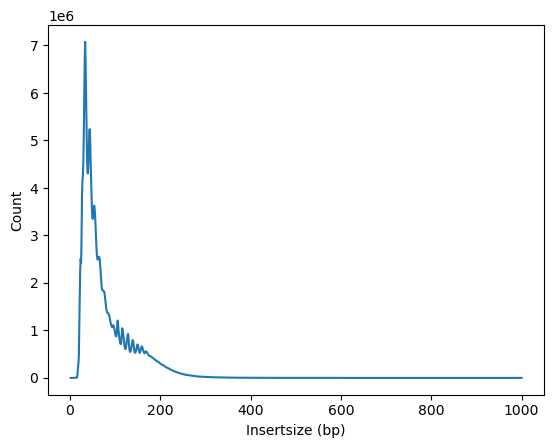

In [11]:
if qc_columns['mean_insertsize'] is None or qc_columns['insertsize_count'] is None:
    
    if use_bam:
        atac.add_insertsize(adata, bam=bam_file, barcode_tag=barcode_tag)     
    else:
        atac.add_insertsize(adata, bam=bam_file, fragments=fragments_file, barcode_tag=barcode_tag)
        
    # update column dictionary
    qc_columns['mean_insertsize'] = 'mean_insertsize'
    qc_columns['insertsize_count'] = 'insertsize_count'
    
    # update infoprocess table
    build_legend(adata, 'mean_insertsize', 'mean_insertsize')
    build_legend(adata, 'insertsize_count', 'insertsize_count')
    
    atac.plot_insertsize(adata, barcodes=None)
    
adata.obs

### 3. promotor enrichment 

In [12]:
if qc_columns['n_fragments_in_promoters'] is None:
    overlap.pct_fragments_in_promoters(adata, gtf_file=promoters_gtf, species=species, bam_file=bam_file, cb_col=None, nproc=1)
    
    # n_total_fragments, n_fragments_in_promoters, pct_fragments_in_promoters
    # update column dictionary
    qc_columns['n_total_fragments'] = 'n_total_fragments'
    qc_columns['n_fragments_in_promoters'] = 'n_fragments_in_promoters'
    qc_columns['pct_fragments_in_promoters'] = 'pct_fragments_in_promoters'
    # update infoprocess table
    build_legend(adata, 'n_total_fragments', 'n_total_fragments')
    build_legend(adata, 'n_fragments_in_promoters', 'n_fragments_in_promoters')
    build_legend(adata, 'pct_fragments_in_promoters', 'pct_fragments_in_promoters')
    

Converting GTF to BED...
Converting BAM to fragments file! This may take a while...
Finished creating fragments file. Now sorting...
Finished sorting fragments
Finding overlaps...
Calculating percentage...
Adding results to adata object...
Done


## Inspect adata.obs

In [ ]:
adata.obs

## Save adata to .h5ad

In [ ]:
adata_output = tree.assembled_anndata
adata_output

In [ ]:
#Saving the data
cr.build_infor(adata, "Test_number", test)
cr.build_infor(adata, "Anndata_path", output_dir)

adata_output = tree.assembled_anndata
adata.write(filename=adata_output)

In [ ]:
import os
import shutil
repo_path = os.getcwd()
notebook_name = '1_assembling.ipynb'
notebook_path = os.path.join(repo_path, notebook_name)
notebook_copy = os.path.join(tree.qc_dir , notebook_name)
shutil.copyfile(notebook_path, notebook_copy)